In [1]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

except Exception as e:
    print(f"Error al importar pandas: {e}")

In [2]:
dfs = [pd.read_csv(f'parte_{i}.csv') for i in range(1, 6)]

# Unir todas las partes en un solo DataFrame y guardarlo en la variable 'frauds'
frauds = pd.concat(dfs, ignore_index=True)
frauds.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
372915,17,CASH_IN,362855.38,C1409848227,31567.00,394422.38,C1049017510,2059223.87,1978056.25,0,0
4864555,348,CASH_IN,92949.52,C1454952220,15759325.56,15852275.09,C683642333,26061110.45,25968160.92,0,0
301069,15,PAYMENT,28800.05,C541448090,0.00,0.00,M449399006,0.00,0.00,0,0
5864328,403,CASH_OUT,104387.26,C1182545365,107633.00,3245.74,C231776241,163577.47,267964.73,0,0
3563288,260,PAYMENT,3535.09,C2058475104,28452.40,24917.31,M1057551999,0.00,0.00,0,0


In [3]:
frauds = frauds[
                        ((frauds['oldbalanceOrg'] == 0) &
                        (frauds['newbalanceOrig'] == 0)) |
                        ((frauds['oldbalanceDest'] == 0) &
                        (frauds['newbalanceDest'] == 0))]


In [4]:
BETTER_COLUMN_NAMES = {
    'step': 'step',
    'type': 'type',
    'amount': 'amount',
    'nameOrig': 'name_origen',
    'oldbalanceOrg': 'old_origen',
    'newbalanceOrig': 'new_origen',
    'nameDest': 'name_destino',
    'oldbalanceDest': 'old_destino',
    'newbalanceDest': 'new_destino',
    'isFraud': 'is_fraud',
    'isFlaggedFraud': 'is_flag_fraud',
}

frauds.rename(columns=BETTER_COLUMN_NAMES, inplace=True)
frauds.sample(5)

,step,type,amount,name_origen,old_origen,new_origen,name_destino,old_destino,new_destino,is_fraud,is_flag_fraud
794183,40,PAYMENT,12453.91,C1203412537,0.0,0.0,M1649336356,0.00,0.00,0,0
186441,13,CASH_OUT,150168.55,C399990871,0.0,0.0,C1846034398,593585.46,743754.00,0,0
1459865,140,TRANSFER,150871.46,C1131916326,0.0,0.0,C838036946,474986.99,625858.45,0,0
3502641,259,PAYMENT,2826.62,C1382031421,0.0,0.0,M1388480788,0.00,0.00,0,0
4765781,334,TRANSFER,3607622.36,C629164692,0.0,0.0,C1260032433,9277625.10,12885247.46,0,0


In [5]:
#dropeamos algunas columnas

frauds = frauds.drop(columns=["is_flag_fraud", "name_origen", "name_destino"])
frauds.sample(3)

,step,type,amount,old_origen,new_origen,old_destino,new_destino,is_fraud
1492448,142,PAYMENT,25257.76,8714.0,0.0,0.00,0.0,0
3317954,252,PAYMENT,6456.53,0.0,0.0,0.00,0.0,0
4543759,326,CASH_OUT,31804.76,0.0,0.0,697850.54,729655.3,0


In [6]:
frauds.isnull().sum()

step           0
type           0
amount         0
old_origen     0
new_origen     0
old_destino    0
new_destino    0
is_fraud       0
dtype: int64

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper

In [8]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(frauds, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((2179195, 8), (726398, 8), (726399, 8))

In [9]:
# Una primer version...
# Definimos el mapper. Recibe una lista de (columna/s, transformers)
mapper = DataFrameMapper([
    (['step'], [StandardScaler()]),
    (['amount'], [StandardScaler()]),
    (['old_origen'], [StandardScaler()]),
    (['new_origen'], [StandardScaler()]),
    (['old_destino'], [StandardScaler()]),
    (['new_destino'], [StandardScaler()]),
    (['type'], [OneHotEncoder()])
])

# Lo entrenamos con train
mapper.fit(train)

c:\Users\Ulises\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


DataFrameMapper(drop_cols=[],
                features=[(['step'], [StandardScaler()]),
                          (['amount'], [StandardScaler()]),
                          (['old_origen'], [StandardScaler()]),
                          (['new_origen'], [StandardScaler()]),
                          (['old_destino'], [StandardScaler()]),
                          (['new_destino'], [StandardScaler()]),
                          (['type'], [OneHotEncoder()])])

In [10]:
# vemos como transforma un sample:
sample = train.sample(5, random_state=42)

# Sample original:
sample

,step,type,amount,old_origen,new_origen,old_destino,new_destino,is_fraud
838329,41,CASH_OUT,131727.83,0.00,0.00,477447.92,609175.75,0
1222071,133,PAYMENT,17106.81,0.00,0.00,0.00,0.00,0
5587259,394,PAYMENT,43298.77,0.00,0.00,0.00,0.00,0
2463315,203,CASH_OUT,95063.48,0.00,0.00,725562.57,820626.06,0
6253845,597,PAYMENT,1604.53,901839.87,900235.34,0.00,0.00,0


In [11]:
# Sample transformado
mapper.transform(sample)

array([[-1.42980762, -0.00859089, -0.20025725, -0.25104227, -0.1149727 ,
        -0.10155676,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-0.77790697, -0.17828854, -0.20025725, -0.25104227, -0.2671046 ,
        -0.27275223,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 1.07150681, -0.13951106, -0.20025725, -0.25104227, -0.2671046 ,
        -0.27275223,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [-0.28189561, -0.06287285, -0.20025725, -0.25104227, -0.03591454,
        -0.04213329,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 2.50993975, -0.20123983,  3.77151918,  4.47632079, -0.2671046 ,
        -0.27275223,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ]])

In [12]:
#mostramos los nombres de las columnas que genera el maper
mapper.transformed_names_

['step',
 'amount',
 'old_origen',
 'new_origen',
 'old_destino',
 'new_destino',
 'type_0',
 'type_1',
 'type_2',
 'type_3',
 'type_4']

In [13]:
lr_model_si = Pipeline([
    ('mapper', mapper),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model_si.fit(train, train.is_fraud)

y_pred = lr_model_si.predict(validation)

y_pred

c:\Users\Ulises\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


array([0, 0, 0, ..., 0, 0, 0])

In [14]:
from sklearn import metrics
metrics.f1_score(validation.is_fraud, y_pred)

#print(metrics.classification_report(validation.is_fraud, y_pred))

np.float64(0.9086057371581054)

In [15]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],        
    }
        
    for i, frauds in enumerate(set_names):
        assert frauds in ['train', 'validation', 'test']
        set_data = globals()[frauds]  # <- hack feo...

        y = set_data.is_fraud
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                     display_labels=['no_fraud', 'fraud'])
            cm_plot.plot(cmap="Blues")
            cm_plot.ax_.set_title(frauds)
        
    display(pd.DataFrame(final_metrics, index=set_names))

'LR Simple Imputer'

,Accuracy,Precision,Recall,F1
train,0.999819,0.992478,0.848132,0.914645
validation,0.999811,0.989826,0.839704,0.908606


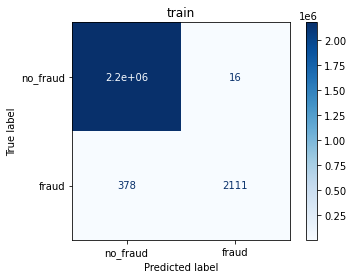

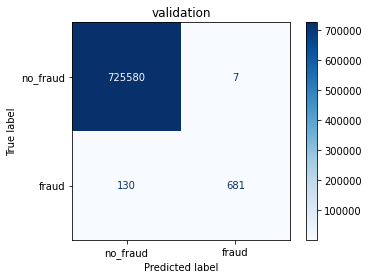

In [16]:
evaluate_model(lr_model_si, title='LR Simple Imputer', show_cm=True)

KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

c:\Users\Ulises\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


'Knn'

,Accuracy,Precision,Recall,F1
train,0.999940,0.992070,0.955002,0.973183
validation,0.999919,0.980818,0.945746,0.962963


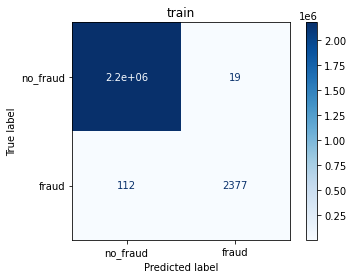

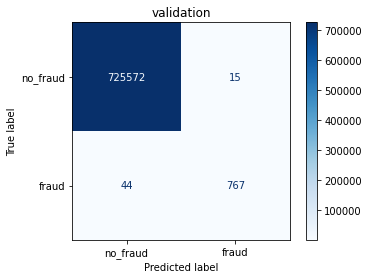

In [18]:
#con k=10 dio 0.96 en f1
K = 10

knn_model = Pipeline([
    ('mapper', mapper),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn_model.fit(train, train.is_fraud)

evaluate_model(knn_model, title='Knn', show_cm=True)

c:\Users\Ulises\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


'Knn'

,Accuracy,Precision,Recall,F1
train,0.999955,0.991776,0.969064,0.980289
validation,0.999926,0.980940,0.951911,0.966208


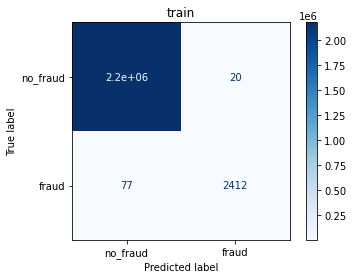

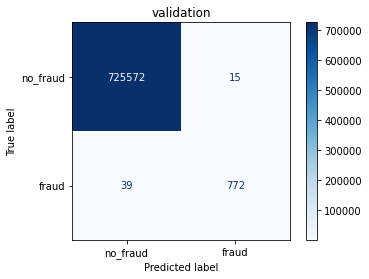

In [20]:
K = 5

knn5_model = Pipeline([
    ('mapper', mapper),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn5_model.fit(train, train.is_fraud)

evaluate_model(knn5_model, title='Knn', show_cm=True) 

c:\Users\Ulises\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


'Knn'

,Accuracy,Precision,Recall,F1
train,0.999971,0.993087,0.981117,0.987065
validation,0.999935,0.982323,0.959309,0.970680


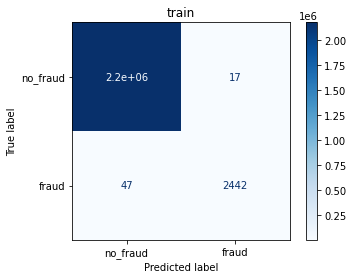

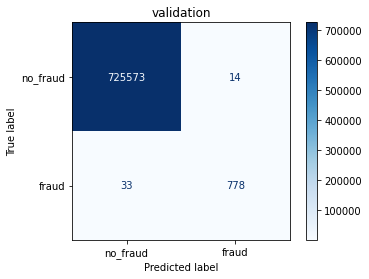

In [22]:
K = 3

knn3_model = Pipeline([
    ('mapper', mapper),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn3_model.fit(train, train.is_fraud)

evaluate_model(knn3_model, title='Knn', show_cm=True) 

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

In [24]:
tree_model = DecisionTreeClassifier(random_state=42)

dt_model = Pipeline([
    ('mapper', mapper),   
    ('classifier', tree_model),
])

dt_model.fit(train, train.is_fraud)

evaluate_model(dt_model, title='Decision Tree')

c:\Users\Ulises\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


'Decision Tree'

,Accuracy,Precision,Recall,F1
train,1.000000,1.000000,1.000000,1.000000
validation,0.999968,0.981663,0.990136,0.985881


In [26]:
tree_model_limit = DecisionTreeClassifier(max_depth=10, random_state=42)

dt_model_limit = Pipeline([
    ('mapper', mapper),
    ('classifier', tree_model_limit),
])

dt_model_limit.fit(train, train.is_fraud)

evaluate_model(dt_model_limit, title='Decision Tree with depth limit')

c:\Users\Ulises\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


'Decision Tree with depth limit'

,Accuracy,Precision,Recall,F1
train,0.999984,0.992379,0.993973,0.993175
validation,0.999959,0.974484,0.988903,0.981640
